# Prototype calculation of cabelling and mixing of density from CM2.6 data <a class="anchor" id="top"> </a>
## Table Of Contents: 
* [Calculate tendency of SST and and SSS from mixing](#first-bullet)
* [Convert to density tendency](#second-bullet)
* [Decompose into the following form](#third-bullet)
* [Save the four terms to dataset](#fourth-bullet)

(Next steps are continued in [tendency-histograms.ipynb](./tendency-histograms.ipynb)

In [69]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [10]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [11]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1321f186a83e47eea1c2c276474aa66c/status,


In [9]:
cluster.close()
client.close()

In [2]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
import gcm_filters
import xgcm

In [3]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
ds

<xarray.Dataset>
Dimensions:            (time: 240, yt_ocean: 2700, xt_ocean: 3600,
                        yu_ocean: 2700, xu_ocean: 3600, nv: 2, st_ocean: 50,
                        st_edges_ocean: 51, sw_edges_ocean: 51, sw_ocean: 50)
Coordinates: (12/14)
    geolat_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_c           (yu_ocean, xu_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * nv                 (nv) float64 1.0 2.0
  * st_edges_ocean     (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
    ...                 ...
  * sw_ocean           (sw_ocean) float64 10.07 20.16 30.29 ... 5.29e+03 5.5e+03
  * time               (time) object 0181-01-16 12:00:00 ... 0200-12-16 12:00:00
  * xt_ocean           (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean           (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
  * yt_ocean           (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean           (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
Data variables: (12/31)
    average_DT         (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    average_T1         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2         (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    eta_t              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    eta_u              (time, yu_ocean, xu_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    frazil_2d          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                 ...
    temp_rivermix      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    time_bounds        (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    ty_trans           (time, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    u                  (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    v                  (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    wt                 (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 50, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:   01810101.ocean.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      CM2.6_miniBling

In [5]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_AREA_WEIGHTED: 2>,
 <GridType.REGULAR_WITH_LAND: 3>,
 <GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>,
 <GridType.IRREGULAR_WITH_LAND: 5>,
 <GridType.MOM5U: 6>,
 <GridType.MOM5T: 7>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 9>,
 <GridType.VECTOR_C_GRID: 10>]

In [6]:
gcm_filters.required_grid_vars(gcm_filters.GridType.MOM5T)

['wet_mask', 'dxt', 'dyt', 'dxu', 'dyu', 'area_t']

In [7]:
grid = xgcm.Grid(ds, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [8]:
hfacc = ds.temp.where(ds.temp == ds.temp.notnull(), 999).where(ds.temp < 999, 111)
mask = hfacc==999

In [16]:
wet_mask = mask[0,0]
dxt = grid.diff(ds.xt_ocean, 'X')
dyt = grid.diff(ds.yt_ocean, 'Y', boundary='fill')
dxu = grid.diff(ds.xu_ocean, 'X',)
dyu = grid.diff(ds.yu_ocean, 'Y', boundary='fill')
area_t = ds.xt_ocean * ds.yt_ocean

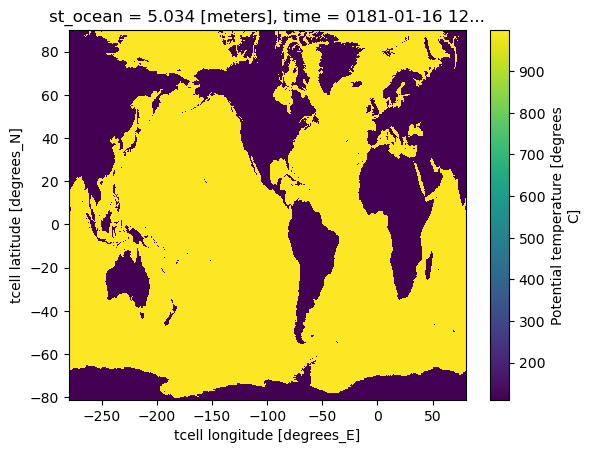

In [13]:
hfacc[0,0].plot()

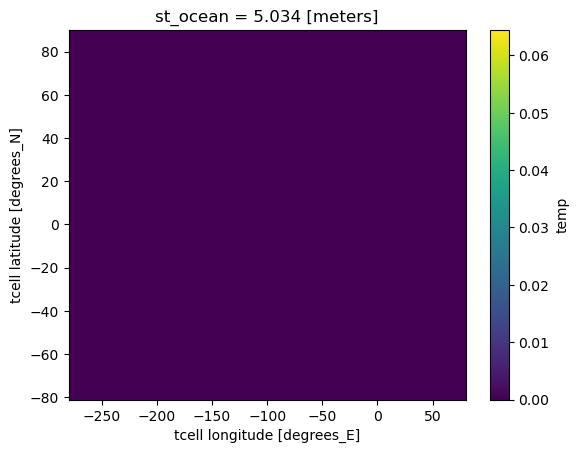

In [14]:
#checking if mask changes through time - it doesn't so define wetmask
mask.std('time')[0].plot()

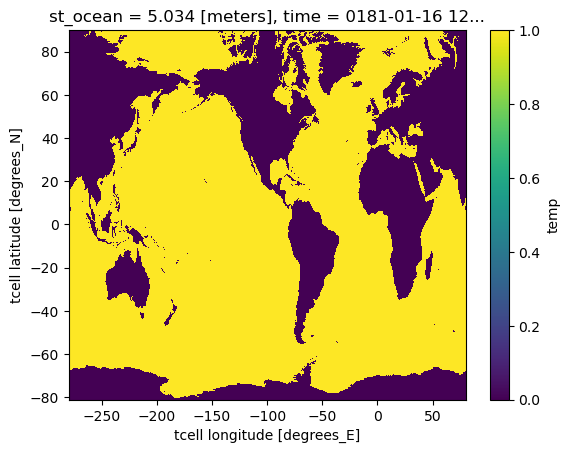

In [18]:
wet_mask.plot()

# 1) Calculate tendency of SST and and SSS from mixing <a class="anchor" id="first-bullet"> </a>